Generate Embeddings from Different Models

In [1]:
from torch.optim import lr_scheduler
import torch.nn as nn
import torch.optim as optim
import torch
import torch.multiprocessing
import numpy as np
import random
import os, sys, glob
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

# import configs
sys.path.insert(0, os.path.abspath('..'))
from data import data_loader
import network.cb_net as net
from configs.params import *
from network import load_model
from torch.nn import functional as F
torch.multiprocessing.set_sharing_strategy('file_system')
print("Imported.")

# Determine if an nvidia GPU is available
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(batch_size)
torch.cuda.manual_seed_all(batch_size)
np.random.seed(batch_size)
random.seed(batch_size)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

if not os.path.exists(os.path.join('../graphs', 'pearson')):
    os.makedirs(os.path.join('../graphs', 'pearson'))

print('Running on device: {}'.format(device)) 
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({'font.size': 17, 'legend.fontsize': 17})    

/home/tiongsik/miniconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Imported.
Running on device: cuda:1


In [2]:
def feature_extractor(model, data_loader, device = 'cuda:0', peri_flag = False, proto_flag = False):    
    emb = torch.tensor([])
    lbl = torch.tensor([], dtype = torch.int64)

    model = model.eval().to(device)
    
    with torch.no_grad():        
        for batch_idx, (x, y) in enumerate(data_loader):
            x = x.to(device)
            x = model(x, peri_flag = peri_flag)

            emb = torch.cat((emb, x.detach().cpu()), 0)
            lbl = torch.cat((lbl, y))
            
            del x, y

    if proto_flag is True:
        lbl_proto = torch.tensor([], dtype = torch.int64)
        emb_proto = torch.tensor([])

        # get unique labels
        for i in torch.unique(lbl):
            # append unique labels to tensor list
            lbl_proto = torch.cat((lbl_proto, torch.tensor([i], dtype=torch.int64)))

            # get index list where unique labels occur
            indices = np.where(lbl == i)
            feats = torch.tensor([])

            # from index list, append features into temporary feats list
            for j in indices:
                feats = torch.cat((feats, emb[j].detach().cpu()), 0)
            # print(feats.shape)
            # get mean of full feats list, and then unsqueeze to append the average prototype value into gal_fea_proto
            proto_mean = torch.unsqueeze(torch.mean(feats, 0), 0)
            proto_mean = F.normalize(proto_mean, p=2, dim=1)
            emb_proto = torch.cat((emb_proto, proto_mean.detach().cpu()), 0)
    
        emb, lbl = emb_proto, lbl_proto

    # print('Set Capacity\t: ', emb.size())
    assert(emb.size()[0] == lbl.size()[0])
    
    del data_loader

    del model
    
    return emb, lbl

In [3]:
peri_gallery_dir = '/home/tiongsik/Python/conditional_biometrics/data/test1_pearson/peri'
face_gallery_dir = '/home/tiongsik/Python/conditional_biometrics/data/test1_pearson/face'
peri_gal_loader, peri_gal_set = data_loader.gen_data(peri_gallery_dir, 'test', type='periocular')
face_gal_loader, face_gal_set = data_loader.gen_data(face_gallery_dir, 'test', type='face')

emb_size = 512
method= 'CB_Net'
load_model_path = '../models/CB_Net/best_model/CB_Net.pth'
model = net.CB_Net(embedding_size = emb_size, do_prob=0.0).eval().to(device)
model = load_model.load_pretrained_network(model, load_model_path, device = device)


In [4]:
emb_peri, lbl_peri = feature_extractor(model, peri_gal_loader, device = device, peri_flag = True)
emb_face, lbl_face = feature_extractor(model, face_gal_loader, device = device, peri_flag = False)

In [5]:
if not os.path.exists(os.path.join('../data', 'pearson', method)):
    os.makedirs(os.path.join('../data', 'pearson', method))
    
torch.save(emb_peri, '../data/pearson/emb_peri.pt')
torch.save(lbl_peri, '../data/pearson/lbl_peri.pt')
torch.save(emb_face, '../data/pearson/emb_face.pt')
torch.save(lbl_face, '../data/pearson/lbl_face.pt')

Draw Graph

In [6]:
import torch
import cv2
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({'font.size': 17, 'legend.fontsize': 14})   

In [7]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [8]:
emb_peri = torch.load('../data/pearson/emb_peri.pt')
lbl_peri = torch.load('../data/pearson/lbl_peri.pt')
emb_face = torch.load('../data/pearson/emb_face.pt')
lbl_face = torch.load('../data/pearson/lbl_face.pt')

In [11]:
emb_face_proto = torch.Tensor([])
emb_peri_proto = torch.Tensor([])
lbl_face_proto = torch.Tensor([])
lbl_peri_proto = torch.Tensor([])

for i in torch.unique(lbl_peri):
    # append unique labels to tensor list
    lbl_peri_proto = torch.cat((lbl_peri_proto, torch.tensor([i], dtype=torch.int64)))

    # get index list where unique labels occur
    indices = np.where(lbl_peri == i)
    feats = torch.tensor([])

    # from index list, append features into temporary face_feats list
    for j in indices:
        feats = torch.cat((feats, emb_peri[j].detach().cpu()), 0)
    proto_mean = torch.unsqueeze(torch.mean(feats, 0), 0)
    proto_mean = F.normalize(proto_mean, p=2, dim=1)
    emb_peri_proto = torch.cat((emb_peri_proto, proto_mean.detach().cpu()), 0)

for i in torch.unique(lbl_face):
    # append unique labels to tensor list
    lbl_face_proto = torch.cat((lbl_face_proto, torch.tensor([i], dtype=torch.int64)))

    # get index list where unique labels occur
    indices = np.where(lbl_face == i)
    feats = torch.tensor([])

    # from index list, append features into temporary face_feats list
    for j in indices:
        feats = torch.cat((feats, emb_face[j].detach().cpu()), 0)
    proto_mean = torch.unsqueeze(torch.mean(feats, 0), 0)
    proto_mean = F.normalize(proto_mean, p=2, dim=1)
    emb_face_proto = torch.cat((emb_face_proto, proto_mean.detach().cpu()), 0)

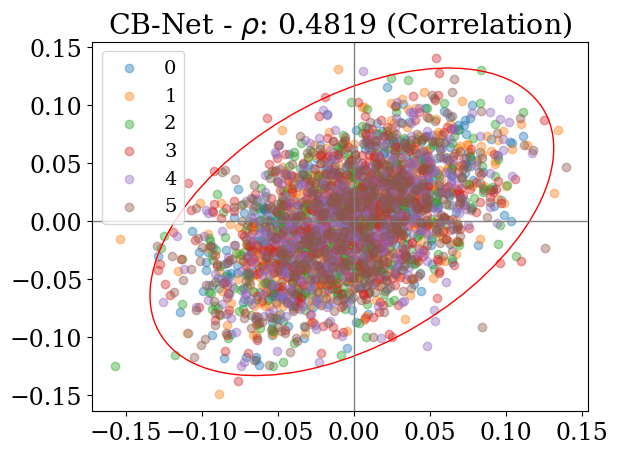

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# baseline
fig, axs = plt.subplots(1, 1)
for i in range(lbl_face_proto.shape[0]):
    x, y = (F.normalize(emb_face_proto[i], p=2, dim=0)).numpy(), (F.normalize(emb_peri_proto[i], p=2, dim=0)).numpy()
    axs.scatter(x, y, alpha=0.4, label = str(lbl_face_proto[i].numpy().astype(int))) 
    # axs.axes.get_yaxis().set_visible(False)
    # axs.axes.get_xaxis().set_visible(False)
    # axs.spines['top'].set_visible(False)
    # axs.spines['right'].set_visible(False)
    # axs.spines['bottom'].set_visible(False)
    # axs.spines['left'].set_visible(False)
axs.axvline(c='grey', lw=1)
axs.axhline(c='grey', lw=1)
confidence_ellipse(x, y, axs, edgecolor='red')
plt.legend()
hist_cmp = cv2.compareHist(emb_face_proto.numpy(), emb_peri_proto.numpy(), cv2.HISTCMP_CORREL)
plt.title('CB-Net - $\\rho$: ' + str(np.around(hist_cmp, 4)) + ' (Correlation)')
plt.savefig('../graphs/pearson/CB_Net_Pearson.pdf', bbox_inches='tight')
plt.show()

LBP

In [14]:
from sklearn import preprocessing
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from skimage import feature
import cv2
import glob

class LocalBinaryPatterns:
  def __init__(self , numPoints , radius):
    self.numPoints = numPoints
    self.radius = radius

  def describe(self , image , eps=1e-7):
    # image = cv2.imread(image, 0)
    # cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
    lbp = feature.local_binary_pattern(image , self.numPoints , self.radius)
    # hist = plt.hist(lbp.ravel())
    return lbp # , hist

def preprocess_img(imagePath, type_root):
    type_root = type_root[:4]
    img = cv2.imread(imagePath, 0)    
    desc = LocalBinaryPatterns(8, 2)   

    if type_root == 'face':
        img = cv2.resize(img, (150, 150))
        lbp = desc.describe(img)
        pca = PCA(1) 
    elif type_root == 'peri':
        img = cv2.resize(img, (150, 50))
        lbp = desc.describe(img)
        pca = PCA(3) 
    reduced = pca.fit_transform(lbp)

    return reduced # , hist     

def read_images(type_root, root = None):
    features = torch.Tensor([])
    label_nms = []
    # type_root = type_root[:4]
    if not root is None:
      dir_root = root
    else:
        dir_root = '/home/tiongsik/Python/conditional_biometrics/data/test1_pearson/' + type_root
    img_path = '**/*.jpg'
    print(os.path.join(dir_root, img_path))
    for name in tqdm(glob.glob(os.path.join(dir_root, img_path))):
        # print(name)
        feats = preprocess_img(name, type_root)
        feats = torch.unsqueeze(torch.Tensor(feats), dim=0)

        features = torch.cat((features, feats), 0)
        label_nm = name.split('/')[-2]
        label_nms.append(label_nm)
  
    # convert label text to integers
    le = preprocessing.LabelEncoder()
    labels = torch.Tensor(le.fit_transform(label_nms))

    return torch.flatten(features, start_dim=1), labels

In [15]:
lbp_emb_peri, lbp_lbl_peri = read_images('peri')
lbp_emb_face, lbp_lbl_face = read_images('face')

/home/tiongsik/Python/conditional_biometrics/data/test1_pearson/peri/**/*.jpg


100%|██████████| 406/406 [00:15<00:00, 25.83it/s]


/home/tiongsik/Python/conditional_biometrics/data/test1_pearson/face/**/*.jpg


100%|██████████| 406/406 [00:24<00:00, 16.75it/s]


In [ ]:
lbp_emb_face_proto = torch.Tensor([])
lbp_emb_peri_proto = torch.Tensor([])
lbp_lbl_face_proto = torch.Tensor([])
lbp_lbl_peri_proto = torch.Tensor([])

for i in torch.unique(lbp_lbl_peri):
    # append unique labels to tensor list
    lbp_lbl_peri_proto = torch.cat((lbp_lbl_peri_proto, torch.tensor([i])))

    # get index list where unique labels occur
    indices = np.where(lbp_lbl_peri == i)
    feats = torch.tensor([])

    # from index list, append features into temporary face_feats list
    for j in indices:
        feats = torch.cat((feats, lbp_emb_peri[j].detach().cpu()), 0)
    proto_mean = torch.unsqueeze(torch.mean(feats, 0), 0)
    proto_mean = F.normalize(proto_mean, p=2, dim=1)
    lbp_emb_peri_proto = torch.cat((lbp_emb_peri_proto, proto_mean.detach().cpu()), 0)

for i in torch.unique(lbp_lbl_face):
    # append unique labels to tensor list
    lbp_lbl_face_proto = torch.cat((lbp_lbl_face_proto, torch.tensor([i])))

    # get index list where unique labels occur
    indices = np.where(lbp_lbl_face == i)
    feats = torch.tensor([])

    # from index list, append features into temporary face_feats list
    for j in indices:
        feats = torch.cat((feats, lbp_emb_face[j].detach().cpu()), 0)
    proto_mean = torch.unsqueeze(torch.mean(feats, 0), 0)
    proto_mean = F.normalize(proto_mean, p=2, dim=1)
    lbp_emb_face_proto = torch.cat((lbp_emb_face_proto, proto_mean.detach().cpu()), 0)

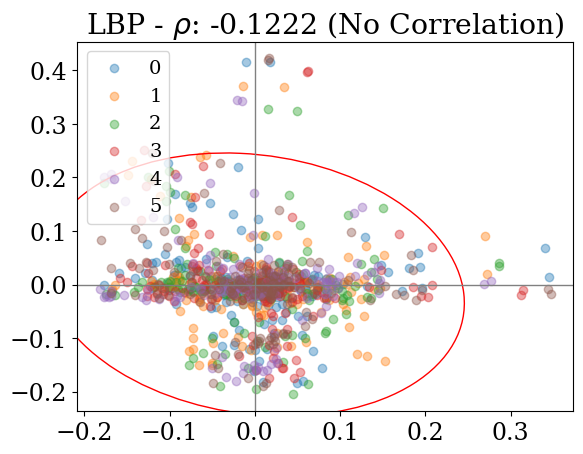

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# dualline
fig, axs = plt.subplots(1, 1)
for i in range(lbp_lbl_face_proto.shape[0]):
    x, y = (F.normalize(lbp_emb_face_proto[i], p=2, dim=0)).numpy(), (F.normalize(lbp_emb_peri_proto[i], p=2, dim=0)).numpy()
    axs.scatter(x, y, alpha=0.4, label = str(lbp_lbl_face_proto[i].numpy().astype(int))) 
    # axs.axes.get_yaxis().set_visible(False)
    # axs.axes.get_xaxis().set_visible(False)
    # axs.spines['top'].set_visible(False)
    # axs.spines['right'].set_visible(False)
    # axs.spines['bottom'].set_visible(False)
    # axs.spines['left'].set_visible(False)
axs.axvline(c='grey', lw=1)
axs.axhline(c='grey', lw=1)
confidence_ellipse(x, y, axs, edgecolor='red')
plt.legend(loc='upper left')
hist_cmp = cv2.compareHist(lbp_emb_face_proto.numpy(), lbp_emb_peri_proto.numpy(), cv2.HISTCMP_CORREL)
plt.title('LBP - $\\rho$: ' + str(np.around(hist_cmp, 4)) + ' (No Correlation)')
plt.savefig('../graphs/pearson/LBP_Pearson.pdf', bbox_inches='tight')
plt.show()